# Gas Standards Plots
Generates plots plots related to gas standards for use in ICOS Labelling reports.

## Initial Setup
Instructions for setting up in a virtual environment (venv). To be run from the folder containing the notebooks.

1. `python -m venv .venv`
2. `source .venv/bin/activate`
3. `pip install pandas matplotlib jupyter ipykernel`
4. `python -m ipykernel install --user --name=.venv`
5. `jupyter notebook`

Open this notebook and make sure it is running using the `.venv` kernel.


## Subsequent Usage
The initial setup above only needs performing once. After that, you need only run:

1. `source .venv/bin/activate`
2. `jupyter notebook`

## Files
The notebook expects two folders: `input` and `output`.

The `input` folder should contain a subfolder for a station, and within that the uncompressed data from a QuinCe export containing at least the "ICOS OTC Labelling" format file.

The `output` folder can be empty; the notebook will take care of creating the necessary folder structure inside it.

## Notebook Initialisation
The cell below will initialise the notebook ready for use

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import os
from scipy.stats import linregress

## Data Setup
Fill in the variables below to match the details of the data to be processed.

| Variable            | Meaning       |
| ------------------- | ------------- |
| `station_name`      | The name of the station. There should be a folder with the same name in the `input` folder. |
| `dataset`           | The name of the dataset exported from QuinCe. This should be the name of the unzipped export from QuinCe within the folder named after the station name. |


In [5]:
station_name = 'Celtic Explorer'
dataset = '45CE20240503'

## General Setup

In [6]:
# Create output folder
output_folder = f'output/{station_name}/{dataset}'
os.makedirs(output_folder, exist_ok=True)

## Load data
Load the data raw data files containing data from the gas standard runs, and extract the columns for:

- Timestamp
- Instrument mode
- Measured CO2

In [33]:
# Setup info for each raw file
separator = '\t'
header_lines = 0

# Instrument mode column info
mode_column = 'Type'
co2_column = 'CO2 um/m'


# Make data frame of timestamp, mode, co2
# Build from each file 1 at a time
df = None
in_dir = f'input/{station_name}/{dataset}/raw/'

for file in sorted(os.listdir(in_dir)):
    if file.endswith('dat.txt'):
        #print(file)
        file_df = pd.read_csv(os.path.join(in_dir, file), sep=separator, skiprows=header_lines, on_bad_lines='skip')
    
        # MAKE THE TIMESTAMP COLUMN
        file_df = file_df.astype({'PC Date': 'string', 'PC Time': 'string'})
        file_df['NOTEBOOK_TIMESTAMP'] = pd.to_datetime(file_df['PC Date'] + ' ' + file_df['PC Time'], format='%d/%m/%y %H:%M:%S')
        
        # Select the columns we want into their own DataFrame and append it to the main df
        selection = file_df[['NOTEBOOK_TIMESTAMP', mode_column, co2_column]]
        selection.columns = ['Timestamp', 'Mode', 'CO2']
    
        df = selection if df is None else df._append(selection, ignore_index=True)

df = df.astype({'Mode': 'string', 'CO2': 'float64'})
df

,Timestamp,Mode,CO2
0,2024-05-03 12:11:23,STD1z,-0.13
1,2024-05-03 12:17:10,STD4s,816.97
2,2024-05-03 12:22:54,STD1,0.11
3,2024-05-03 12:23:57,STD1,0.10
4,2024-05-03 12:25:02,STD1,0.05
...,...,...,...
82984,2024-09-18 07:11:41,EQU,533.28
82985,2024-09-18 07:13:10,EQU,534.34
82986,2024-09-18 07:13:32,FILTER,NaN
82987,2024-09-18 07:19:37,STD1,0.00


## Prepare data

1. Specify which modes are of interest and supply their concentrations.
2. Truncate all mode names and remove any that aren't required.
3. Calculate the gas standard anomalies
4. Calculate time offsets for drift calculation
5. Remove large outliers


In [45]:
modes_and_concentrations = {
    'STD1': 0,
    'STD2': 244.26,
    'STD3': 459.98,
    'STD4': 817.1
}

outlier_limit = 5

plot_modes = {k: v for k, v in modes_and_concentrations.items() if v > 0}

# Truncate modes to their base names
for mode in modes_and_concentrations.keys():
    print(mode)
    df['Mode'] = df['Mode'].replace(f'{mode}.*', mode, regex=True)

# Remove unneeded rows
df = df[df['Mode'].isin(modes_and_concentrations.keys())].reset_index(drop=True)

# Calculate the gas standard anomalies
df['Anomaly'] = df['CO2'] - df['Mode'].map(modes_and_concentrations)
df = df.astype({'Anomaly': 'float64'})
df['Absolute_Anomaly'] = abs(df['Anomaly'])

# Calculate time offsets
df['Days'] = (df['Timestamp'] - df['Timestamp'][0]).apply(lambda x: x.total_seconds() / 86400)

# Remove outliers
df = df.query(f'Absolute_Anomaly <= {outlier_limit}')

df.reset_index()
df

STD1
STD2
STD3
STD4


,Timestamp,Mode,CO2,Anomaly,Absolute_Anomaly,Days
0,2024-05-03 12:11:23,STD1,-0.13,-0.13,0.13,0.000000
1,2024-05-03 12:17:10,STD4,816.97,-0.13,0.13,0.004016
2,2024-05-03 12:22:54,STD1,0.11,0.11,0.11,0.007998
3,2024-05-03 12:23:57,STD1,0.10,0.10,0.10,0.008727
4,2024-05-03 12:25:02,STD1,0.05,0.05,0.05,0.009479
...,...,...,...,...,...,...
17336,2024-09-18 05:38:19,STD2,244.59,0.33,0.33,137.727037
17337,2024-09-18 05:44:23,STD3,459.07,-0.91,0.91,137.731250
17338,2024-09-18 05:45:27,STD3,459.04,-0.94,0.94,137.731991
17339,2024-09-18 05:46:31,STD3,458.99,-0.99,0.99,137.732731


## Stats


### Distribution of anomalies

In [52]:
thresholds = [2, 5, 1000000]

for mode in plot_modes:
    mode_data = df[df['Mode'] == mode]

    results = list()
    last_total = 0

    for threshold in thresholds:
        in_threshold = mode_data[mode_data['Absolute_Anomaly'] <= threshold]

        threshold_records = len(in_threshold) - last_total

        threshold_fraction = threshold_records / len(mode_data)

        results.append(threshold_fraction * 100)

        last_total += threshold_records
        

    line = f'{mode}: {results}'

    print(line)


STD2: [97.76049033474776, 2.2395096652522395, 0.0]
STD3: [90.92000960845544, 9.079990391544559, 0.0]
STD4: [97.8843124015305, 2.1156875984695027, 0.0]


# Calculate Drift
Calculate the drift for each gas standard over time


In [53]:
drift = dict()

for mode in plot_modes.keys():
    
    mask = df['Mode'] == mode
    fit = linregress(df.loc[mask, 'Days'], df.loc[mask, 'Anomaly'])
    drift[mode] = fit

    print(f'{mode} {fit.slope:.4f} {fit.pvalue:.2f}')    


STD2 -0.0000 0.90
STD3 -0.0001 0.63
STD4 0.0013 0.00


# Plot Setup

### Plot anomalies over time

In [54]:
plot_modes = {k: v for k, v in modes_and_concentrations.items() if v > 0}
plot_colours = ['darkred', 'blue', 'orange']


<Figure size 640x480 with 0 Axes>

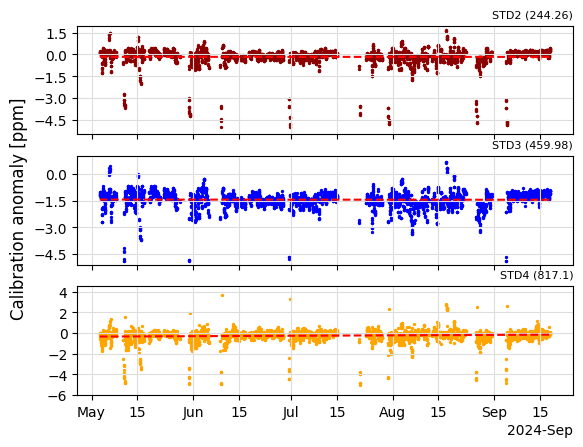

In [86]:
y_ranges = [[-5.5, 2], [-5.1, 1], [-6, 4.5]]
y_ticks = [1.5, 1.5, 2]

plt.figure()

plot_index = 0
fig, axs = plt.subplots(len(plot_modes), 1)

for mode in plot_modes.keys():
    
    mask = df['Mode'] == mode
    axs[plot_index].scatter(df.loc[mask, 'Timestamp'], df.loc[mask, 'Anomaly'],
                            color=plot_colours[plot_index], s=2)
    
    slope = drift[mode].slope
    intercept = drift[mode].intercept
    
    
    axs[plot_index].plot([df['Timestamp'][0], df['Timestamp'].iloc[-1]],
                         [intercept, slope * df['Days'].iloc[-1] + intercept],
                         color='red', linestyle='dashed')
    
    axs[plot_index].set_ylim(y_ranges[plot_index])
    axs[plot_index].grid(color='#dddddd')
    axs[plot_index].yaxis.set_major_locator(MultipleLocator(y_ticks[plot_index]))

    axs[plot_index].set_title(f'{mode} ({modes_and_concentrations[mode]})', loc='right', size=8)
    
    
    if plot_index < len(plot_modes) - 1:
       axs[plot_index].set_xticklabels('')
    else:
        locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        axs[plot_index].xaxis.set_major_formatter(formatter)

    plot_index += 1


fig.supylabel('Calibration anomaly [ppm]')

output_path = f'{output_folder}/gas_standard_anomalies_time.png'
plt.savefig(output_path, dpi=400, bbox_inches='tight')

plt.show()

### Box Plots

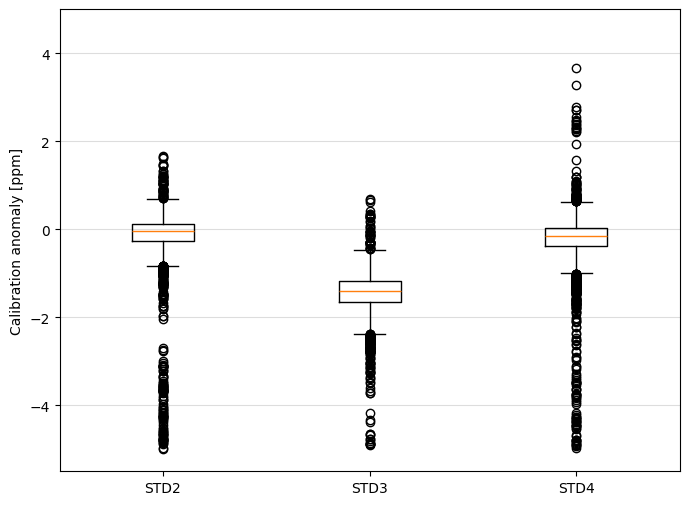

In [71]:
box_plot_data = list()

for mode in plot_modes.keys():
    mask = df['Mode'] == mode
    box_plot_data.append(df.loc[mask, 'Anomaly'])

plt.figure(figsize=(8, 6))

plt.boxplot(box_plot_data)
plt.ylim(-5.5, 5)
plt.ylabel('Calibration anomaly [ppm]')
plt.xticks(range(1, len(plot_modes.keys()) + 1), labels=plot_modes.keys())
plt.grid(axis='y', color='#dddddd')

output_path = f'{output_folder}/gas_standard_anomalies_boxplot.png'
plt.savefig(output_path, dpi=400, bbox_inches='tight')

plt.show()